![dask.png](figs/dask.png)

### Dask installation:
`` pip install "dask[complete]" pyarrow s3fs graphviz``

In [1]:
import numpy as np
import time
import os

import dask
import dask.dataframe as dd
from dask.distributed import LocalCluster, Client
import dask.array as da
import pandas as pd



In [2]:
import os
# The jupyter notebook is launched from your $HOME directory.
# Change the working directory to the workshop directory
# which was created in your username directory under /scratch/vp91
os.chdir(os.path.expandvars("/scratch/vp91/$USER/"))

### Dask Collections

* **High-level collections**: Mimic NumPy, lists, and pandas but can operate in parallel on datasets that don’t fit into memory 
    * Array
    * DataFrame
    * Bag
    
* **Low-level collections**: Give finer control to build custom parallel and distributed computations
    * Delayed
    * Futures



# Dask Dataframes

![dataframe.png](figs/dataframe.png)

* One Dask DataFrame is comprised of many in-memory pandas DataFrames separated along the index. 
* One operation on a Dask DataFrame triggers many pandas operations on the constituent pandas DataFrames 
* These operations are mindful of potential parallelism and memory constraints.

In [3]:
!ls distributed-computing-in-dask/data/nycflights/*.csv

distributed-computing-in-dask/data/nycflights/1990.csv
distributed-computing-in-dask/data/nycflights/1991.csv
distributed-computing-in-dask/data/nycflights/1992.csv
distributed-computing-in-dask/data/nycflights/1993.csv
distributed-computing-in-dask/data/nycflights/1994.csv
distributed-computing-in-dask/data/nycflights/1995.csv
distributed-computing-in-dask/data/nycflights/1996.csv
distributed-computing-in-dask/data/nycflights/1997.csv
distributed-computing-in-dask/data/nycflights/1998.csv
distributed-computing-in-dask/data/nycflights/1999.csv


In [4]:
# Read all the csv file into a single Dask dataframe
ddf = dd.read_csv(
    os.path.join("distributed-computing-in-dask/data", "nycflights", "*.csv"), parse_dates={"Date": [0, 1, 2]}
)

* dask.dataframe.read_csv only reads in a sample from the beginning of the file
* These inferred datatypes are then enforced when reading all partitions
* Sometimes, datatypes inferred in the sample can be incorrect. 
    * The first n rows have no value for CRSElapsedTime (which pandas infers as a float), and later on turn out to be strings (object dtype). 

* Good practice - specify dtypes directly using the dtype keyword. 

In [7]:
ddf = dd.read_csv(
    os.path.join("distributed-computing-in-dask/data", "nycflights", "*.csv"),
    parse_dates={"Date": [0, 1, 2]},
    dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
)   

In [8]:
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,string,int64,string,float64,float64,float64,float64,float64,string,string,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Lazy evaluation
* Representation of the DataFrame object contains no data 
* Dask has just done enough to read the start of the first file, and infer the column names and dtypes

* Dask **constructs** the logic (called task graph) of your computation immediately
* **Evaluates** them only when necessary

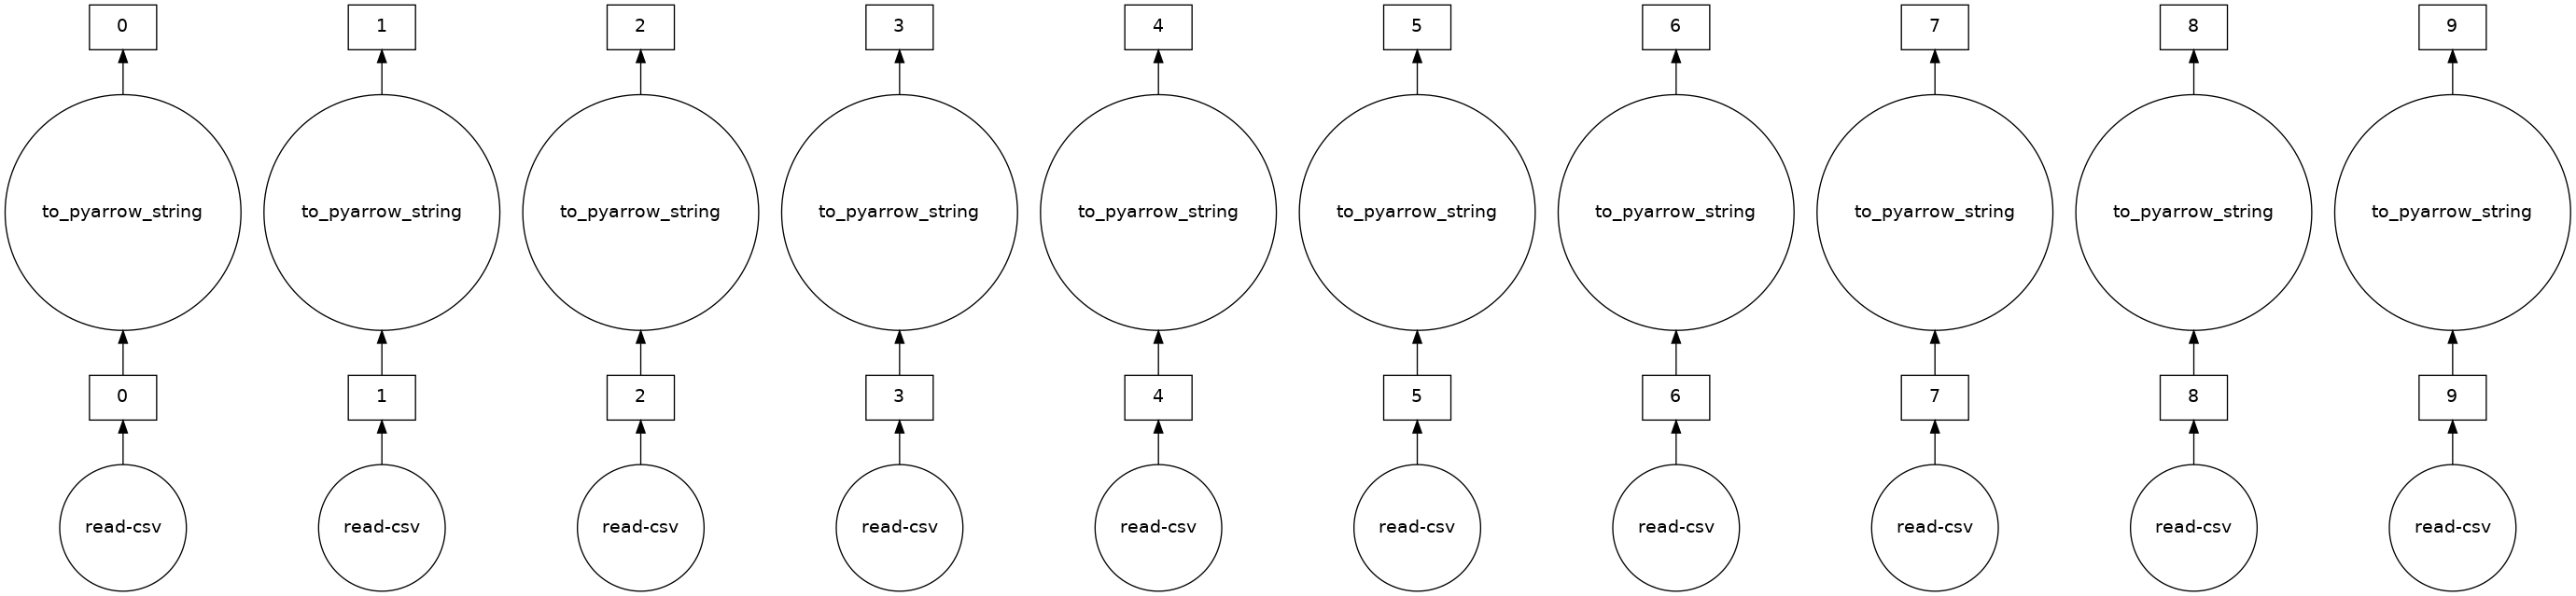

In [9]:

ddf.visualize()

* Functions like len, head, tail also trigger an evaluation.
    * load actual data, (that is, load each file into a pandas DataFrame)
    * apply the corresponding functions to each pandas DataFrame (also known as a partition)
    * combine the subtotals to give you the final grand total

In [10]:
len(ddf)

2611892

In [11]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,<NA>,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,<NA>,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,<NA>,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,<NA>,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,<NA>,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


### Operation on multiple files in Pandas

In [17]:
%%time

# find the max value of the DepDelay coulmn in all the 10 dataframes
files = os.listdir(os.path.join('distributed-computing-in-dask/data', 'nycflights'))
maxes = []

for file in files:
    df = pd.read_csv(os.path.join('distributed-computing-in-dask/data', 'nycflights', file))
    maxes.append(df.DepDelay.max())

final_max = max(maxes)
print(final_max)

1435.0
CPU times: user 3.03 s, sys: 194 ms, total: 3.22 s
Wall time: 3.23 s


### Operation on multiple files in Dask

In [18]:
# find the max value of the DepDelay coulmn in all the 10 dataframes


# This only creates the task graph, it does not execute the operation
result = ddf.DepDelay.max()

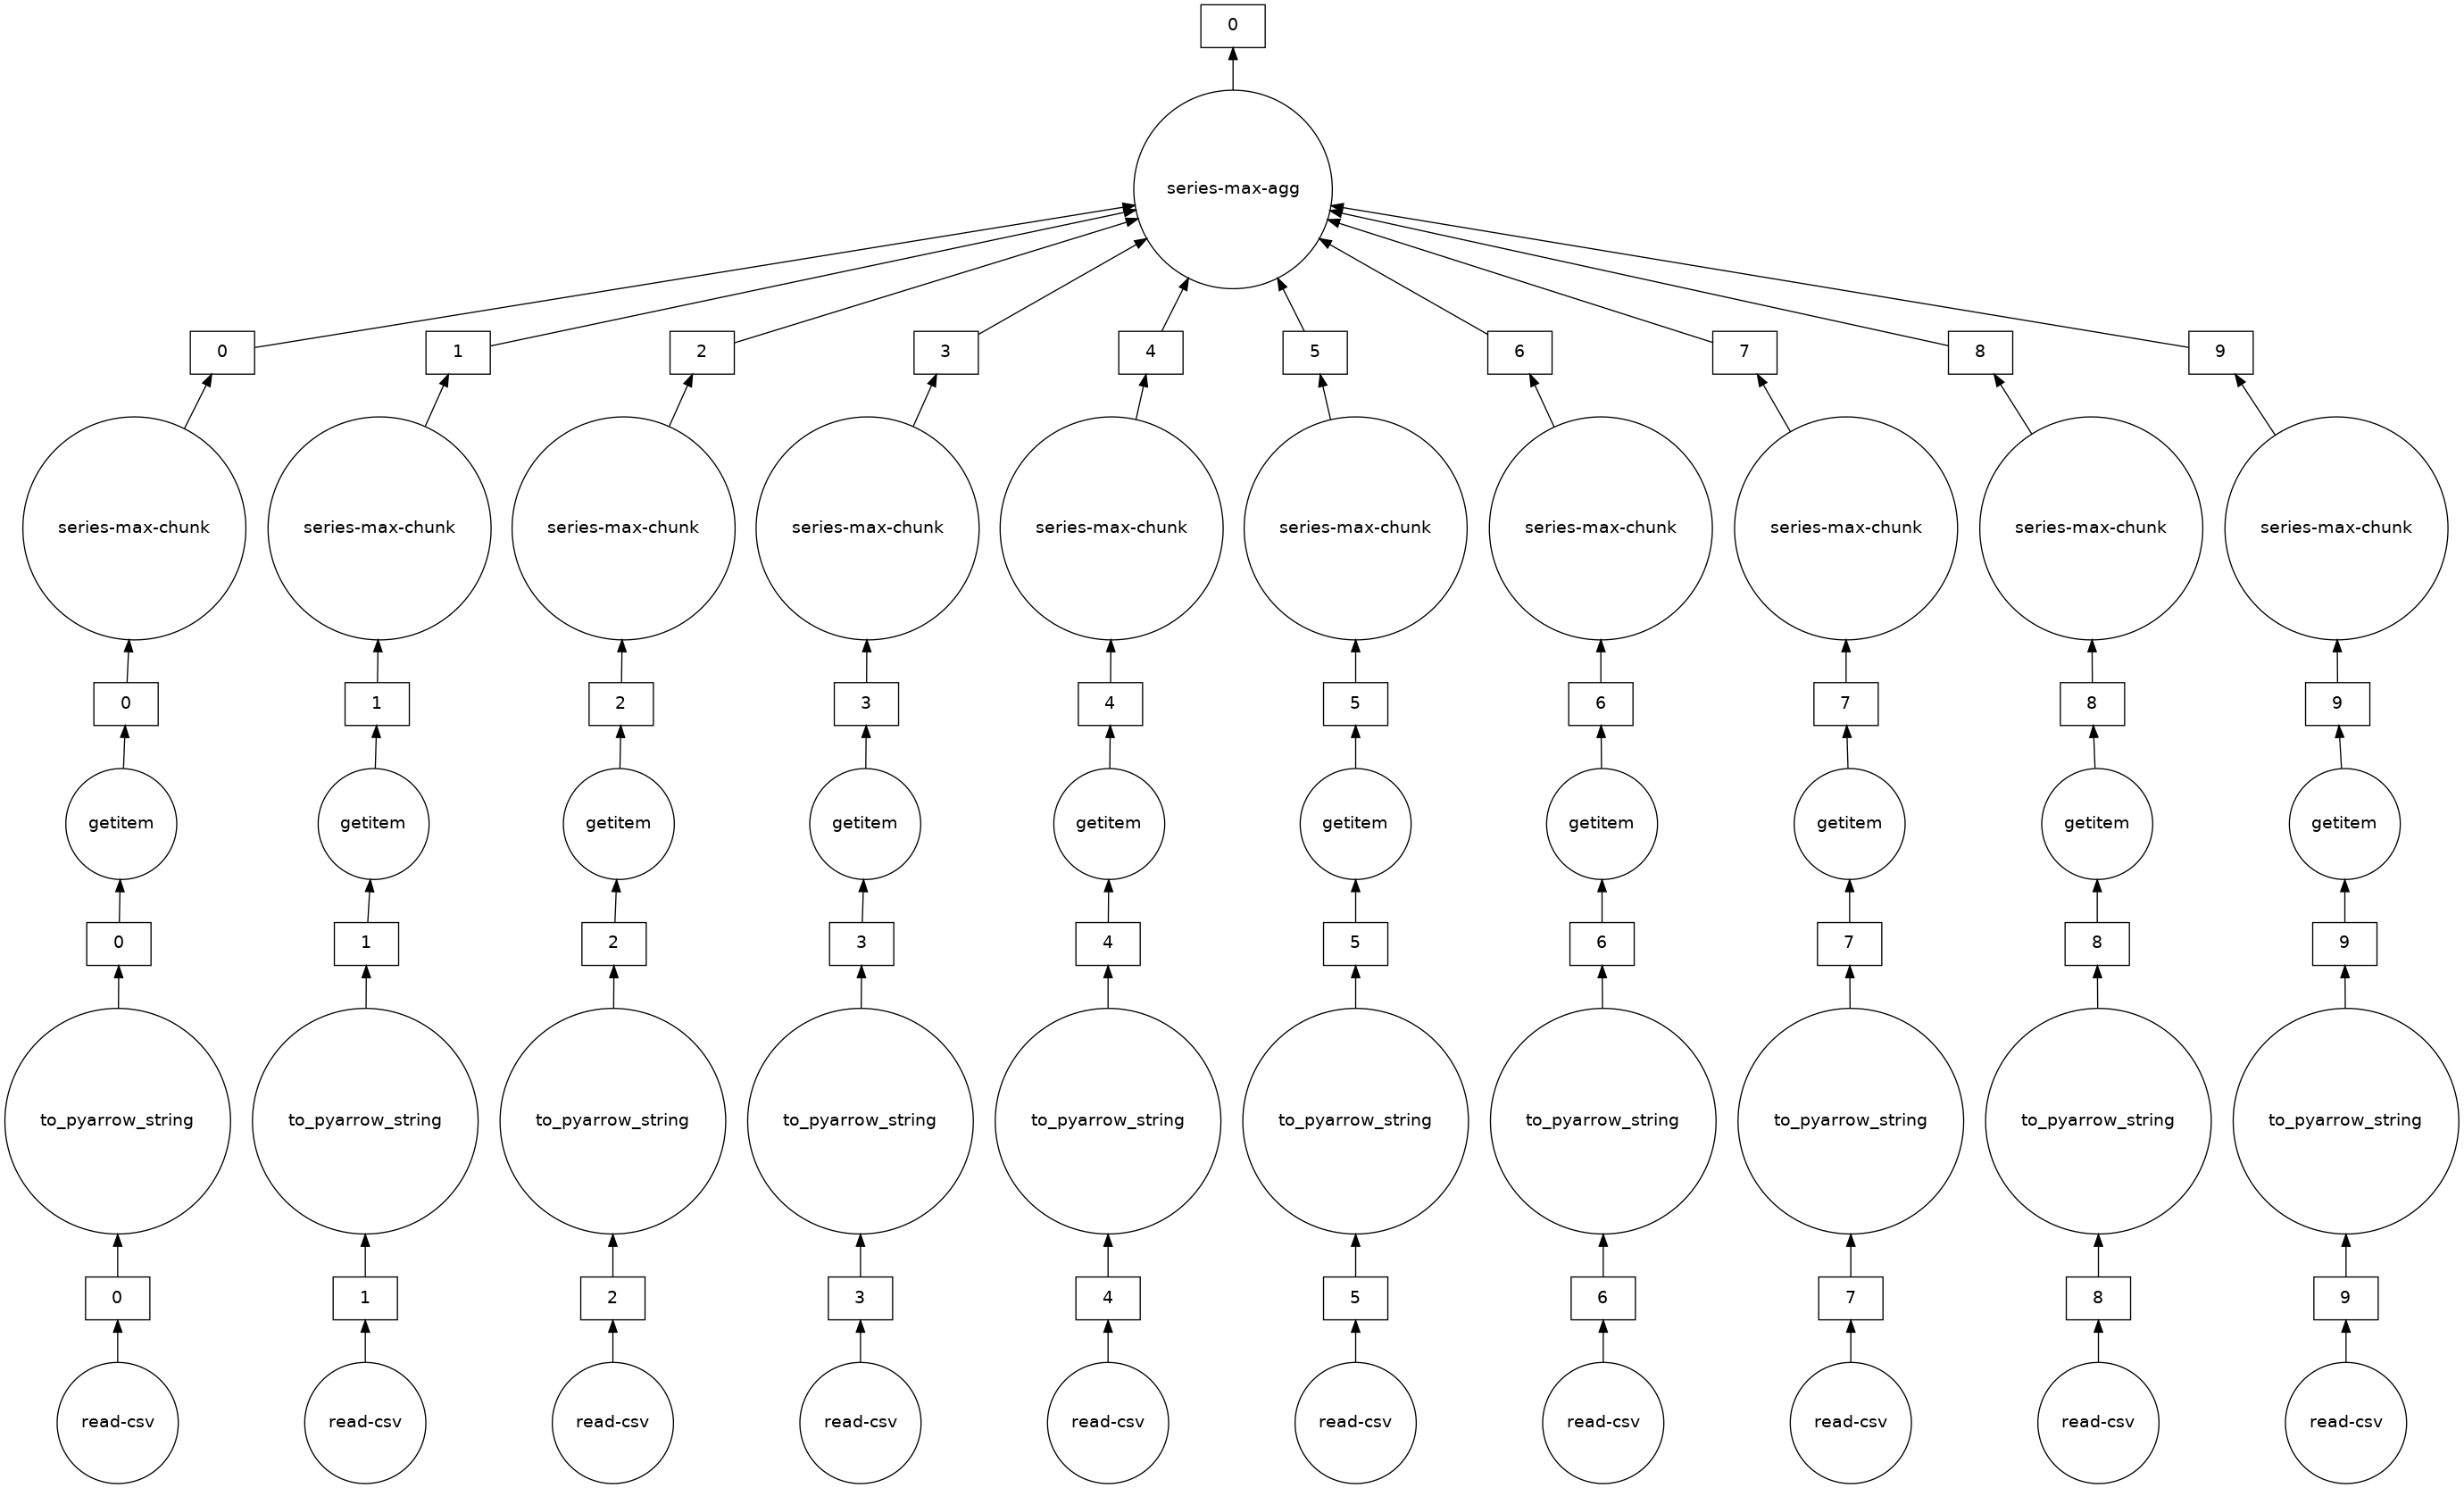

In [19]:
result.visualize()

In [20]:
%%time
result.compute()

CPU times: user 10.7 s, sys: 828 ms, total: 11.6 s
Wall time: 4.42 s


1435.0

### Excercise: Find the number of flight from each city

* We can also combine multiple compute steps into a single instruction
* This is usualy more efficient
    * Task graphs for both results are merged when calling dask.compute
    * shared operations to only be done once instead of twice

In [21]:
non_canceled = ddf[~ddf.Cancelled]
mean_delay = non_canceled.DepDelay.mean()
std_delay = non_canceled.DepDelay.std()

In [22]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 22.4 s, sys: 1.08 s, total: 23.4 s
Wall time: 8.86 s


In [23]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 11.6 s, sys: 520 ms, total: 12.1 s
Wall time: 4.42 s


# Dask  Arrays - parallelized numpy

![arrays.png](figs/arrays.png)

* Dask Array implements a subset of the NumPy ndarray interface using **blocked** algorithms
* Large array is cut into many small arrays
* Large computations are performed by combining many smaller computations

In [24]:

# NumPy array
a_np = np.ones(10)
a_np

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
# This is how a blocked operation is done in numpy. We divide the whole ndarray
# of size 10 int slices of 2, each of size 5

a_np_sum = a_np[:5].sum() + a_np[5:].sum()
a_np_sum

10.0

In [26]:
# Dask array

# In task ndarray we specify the slices usinh the keyword chunk. 
# chunk defines the numer of elements in each slice

a_da = da.ones(33, chunks=5)
a_da

dask.array<ones_like, shape=(33,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

In [27]:
a_da_sum = a_da.sum()
a_da_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

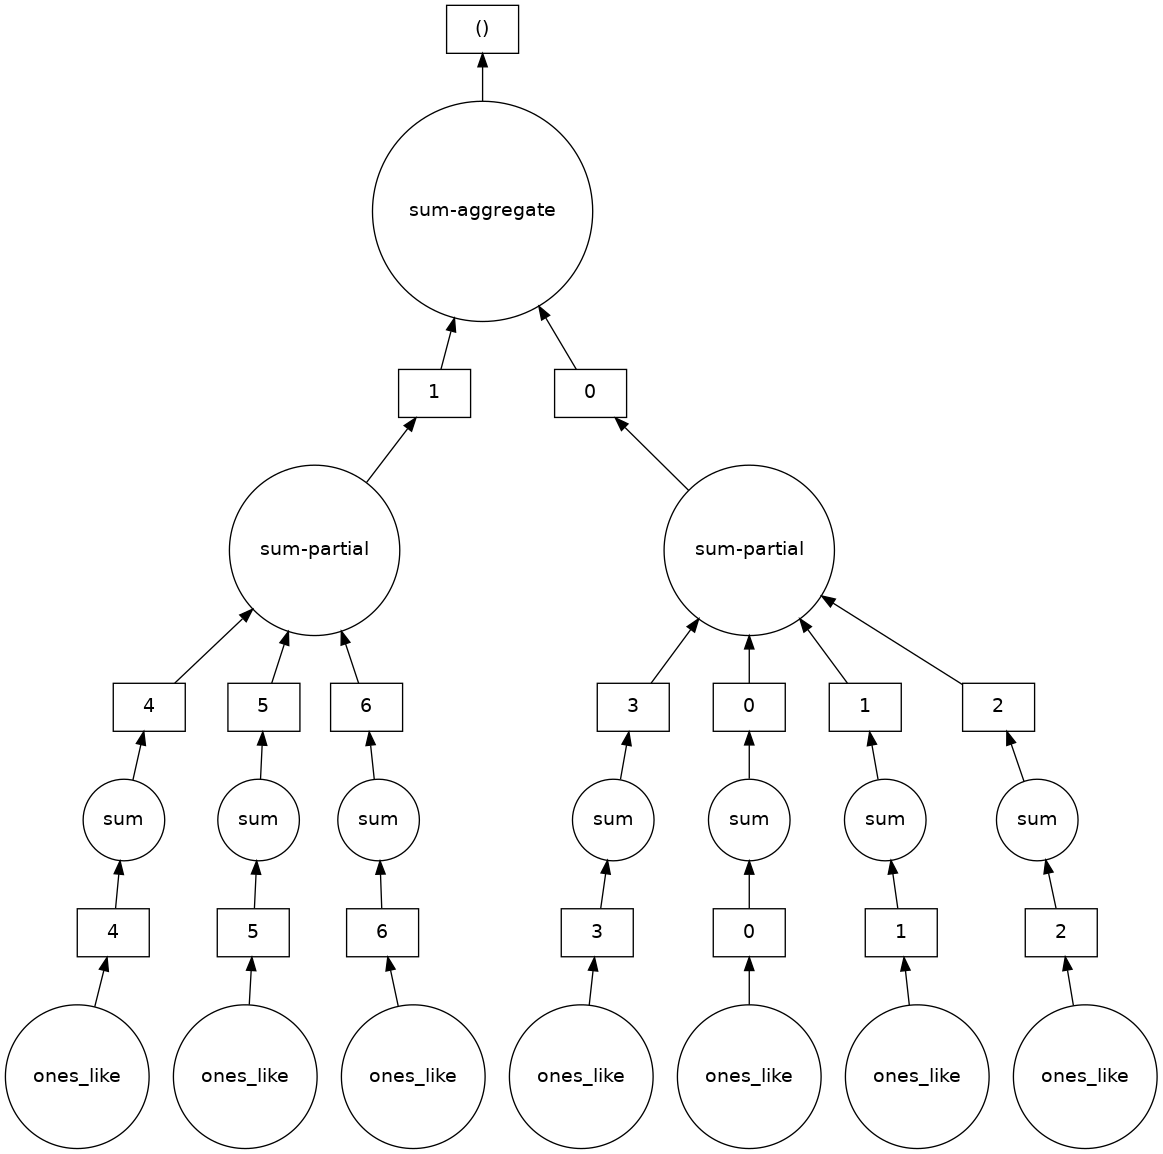

In [28]:
a_da_sum.visualize()

In [29]:
%%time
a_da_sum.compute()

CPU times: user 5.56 ms, sys: 842 µs, total: 6.4 ms
Wall time: 6.11 ms


33.0

* Dask can also find an optimal chunk by itself
* If your chunks are too small
    * the amount of actual work done by every task is very tiny
    * the overhead of coordinating all these tasks results in a very inefficient process
* If your chunks are too big
    * you will likely run out of memory
    * data will have to be moved to the disk 
    * this will lead to performance decrements

In [30]:
%%time

xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000)) # We specify the chunk
yd = xd.mean(axis=0)
yd.compute()

CPU times: user 26.9 s, sys: 1.29 s, total: 28.2 s
Wall time: 1.43 s


array([10.00116525, 10.00008471,  9.99979087, ...,  9.99951313,
       10.00043655,  9.99995502])

In [31]:
%%time

xd = da.random.normal(10, 0.1, size=(30_000, 30_000)) # Dask finds the chunk
yd = xd.mean(axis=0)
yd.compute()

CPU times: user 27 s, sys: 1.17 s, total: 28.1 s
Wall time: 1.56 s


array([10.00023415, 10.00055928, 10.00054332, ...,  9.99865014,
        9.99960185,  9.99934679])

In [32]:
xd.chunksize

(4096, 4096)

# Delayed decorator

* A Block of code can have operations that can happen in parallel
* Normally in python these operation will happen sequentially
    * Or the user will identify the parallel section and write parallel codes
* The Dask **delayed** function decorates your functions so that they operate lazily 
* Dask will defer execution of the function, placing the function and its arguments into a task graph
* Dask will then identify oppurtunities for parallelism in the task graph
* The Dask schedulers will exploit this parallelism, generally improving performance

In [33]:
@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1




In [34]:
@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

In [35]:
# As the two increments are independent of each other, we can run them in parallel

x = inc(1)
y = inc(2)
z = add(x, y)

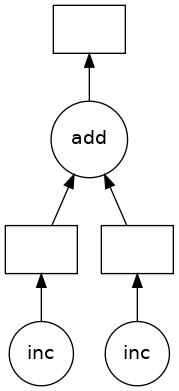

In [36]:
# Here Z is a delayed object

z.visualize()

In [37]:
z.compute()

5

# Dask future

* we can submit individual functions for evaluation
* The call returns immediately, giving one or more future
    * whose status begins as “pending”
    * later becomes “finished”
* There is no **blocking** of the local Python session.

* Difference between futures and delayed
    * delayed is lazy (it just constructs a graph) 
    * futures are eager. 
    * With futures, as soon as the inputs are available and there is compute available, the computation starts

In [39]:
client = Client(n_workers=4)

def inc(x):
    time.sleep(1)
    return x + 1


def double(x):
    sleep(2)
    return 2 * x


def add(x, y):
    time.sleep(1)
    return x + y

In [40]:
future = client.submit(inc, 1)  # returns immediately with pending future
future

<Future: pending, key: inc-85ae4789b7429b2aac5c460b3bff3134>

#### If we check the future after a few seconds we can see that it is complete

In [41]:
future

<Future: finished, type: int, key: inc-85ae4789b7429b2aac5c460b3bff3134>

In [42]:

future.result()

2

2023-11-15 11:24:48,139 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,143 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,148 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,219 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,223 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,228 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,527 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,530 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:48,535 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:49,548 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:49,551 - distributed.nanny - WARNING - Restarting worker
2023-11-15 11:24:49,556 - distributed.nanny - WARNING - Restarting worker


In [ ]:
client.close()

# Distributed Dask 

![dask_cluster.png](figs/dask_cluster.png)

* Dask can work on a clusteer
* We have been using the distributed scheduler for our work, but just on a single machine.
* When we instantiate a Client() object with no arguments it will attempt to locate a Dask cluster
    * It will check your local Dask config and environment variables to see if connection information has been specified
    * If not it will create an instance of LocalCluster and use that

In [ ]:
cluster = LocalCluster()
cluster

In [ ]:
cluster.get_logs()

In [ ]:
client = Client(cluster)
client

In [ ]:

del client, cluster

## Compute Vs Persist

In [ ]:
df = dask.datasets.timeseries()
df.npartitions

In [ ]:
type(df)

In [ ]:
computed_df = df.compute()
type(computed_df)

In [ ]:
df_persist = df.persist()
type(df_persist)

In [ ]:
df_persist.npartitions